<a href="https://colab.research.google.com/github/josebenitezg/vision-transformer-from-scratch/blob/main/vision_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

attention.png  data  experiments  metrics.png  sample_data


In [72]:
#@title ViT Implementation 🔥
import math
import torch
from torch import nn


class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
#@title Prepare Data 📊
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

In [75]:
#@title Utils 🛠️
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'MNIST ' #@param {type:"string"}
batch_size = 256 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.01  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


100%|██████████| 170498071/170498071 [00:05<00:00, 29341754.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.8766, Test loss: 1.6684, Accuracy: 0.3781
Epoch: 2, Train loss: 1.5706, Test loss: 1.4504, Accuracy: 0.4765
Epoch: 3, Train loss: 1.4083, Test loss: 1.4127, Accuracy: 0.4872
Epoch: 4, Train loss: 1.3519, Test loss: 1.2688, Accuracy: 0.5375
Epoch: 5, Train loss: 1.2937, Test loss: 1.2398, Accuracy: 0.5512
Epoch: 6, Train loss: 1.2506, Test loss: 1.2331, Accuracy: 0.5508
Epoch: 7, Train loss: 1.2206, Test loss: 1.2314, Accuracy: 0.5514
Epoch: 8, Train loss: 1.2055, Test loss: 1.1965, Accuracy: 0.5630
Epoch: 9, Train loss: 1.1758, Test loss: 1.1772, Accuracy: 0.5710
Epoch: 10, Train loss: 1.1436, Test loss: 1.1979, Accuracy: 0.5657
Epoch: 11, Train loss: 1.1132, Test loss: 1.1230, Accuracy: 0.6043
Epoch: 12, Train loss: 1.0966, Test loss: 1.1055, Accuracy: 0.6066
Epoch: 13, Train loss: 1.0767, Test loss: 1.1357, Accuracy: 0.5941
Epoch: 14, Train loss: 1.0576, Test loss: 1.1212, Accuracy: 0.6022
Epoch: 15, Train loss: 1.0383, Test loss: 1.1195, Accuracy: 0.6060
Epoc

Files already downloaded and verified


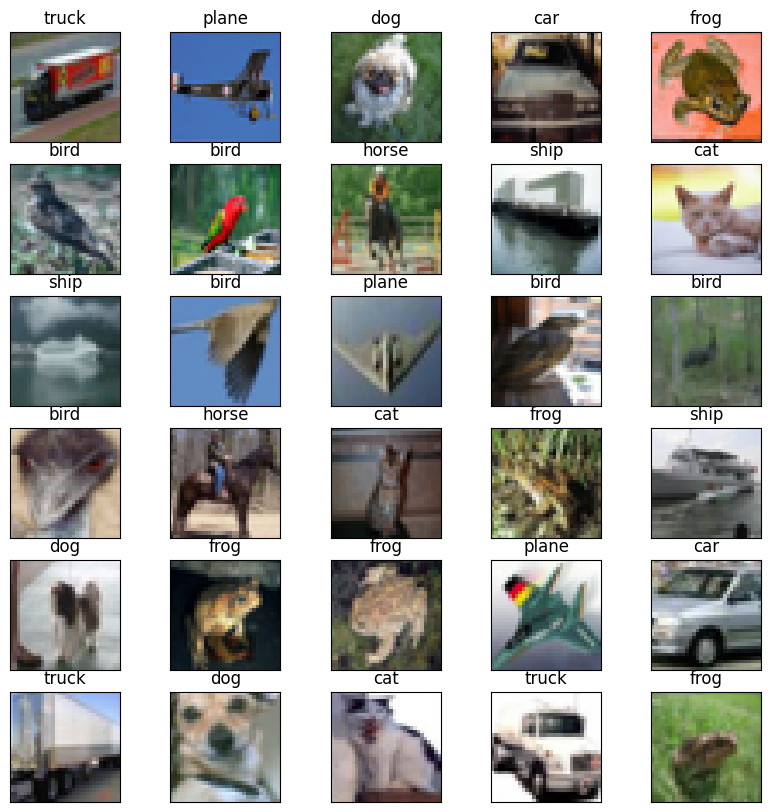

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

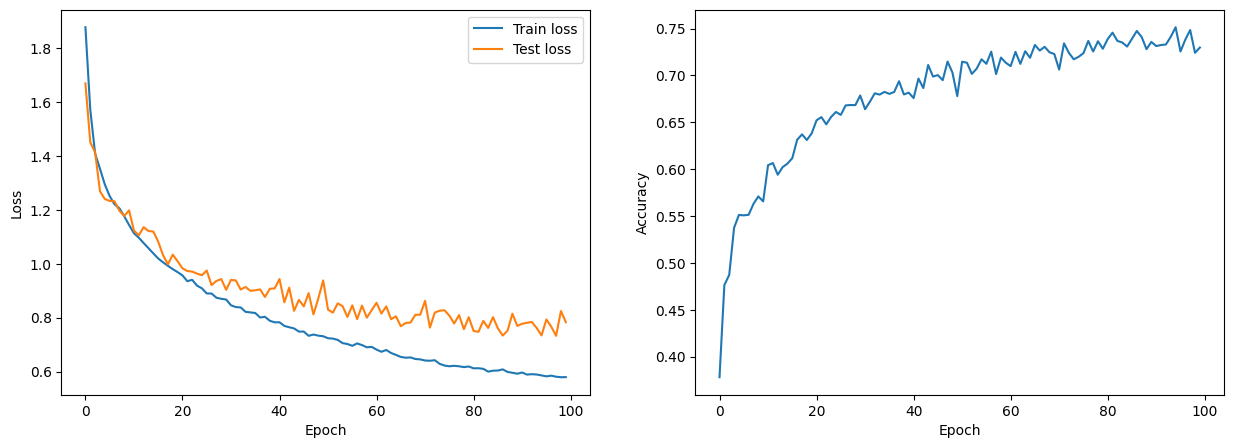

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


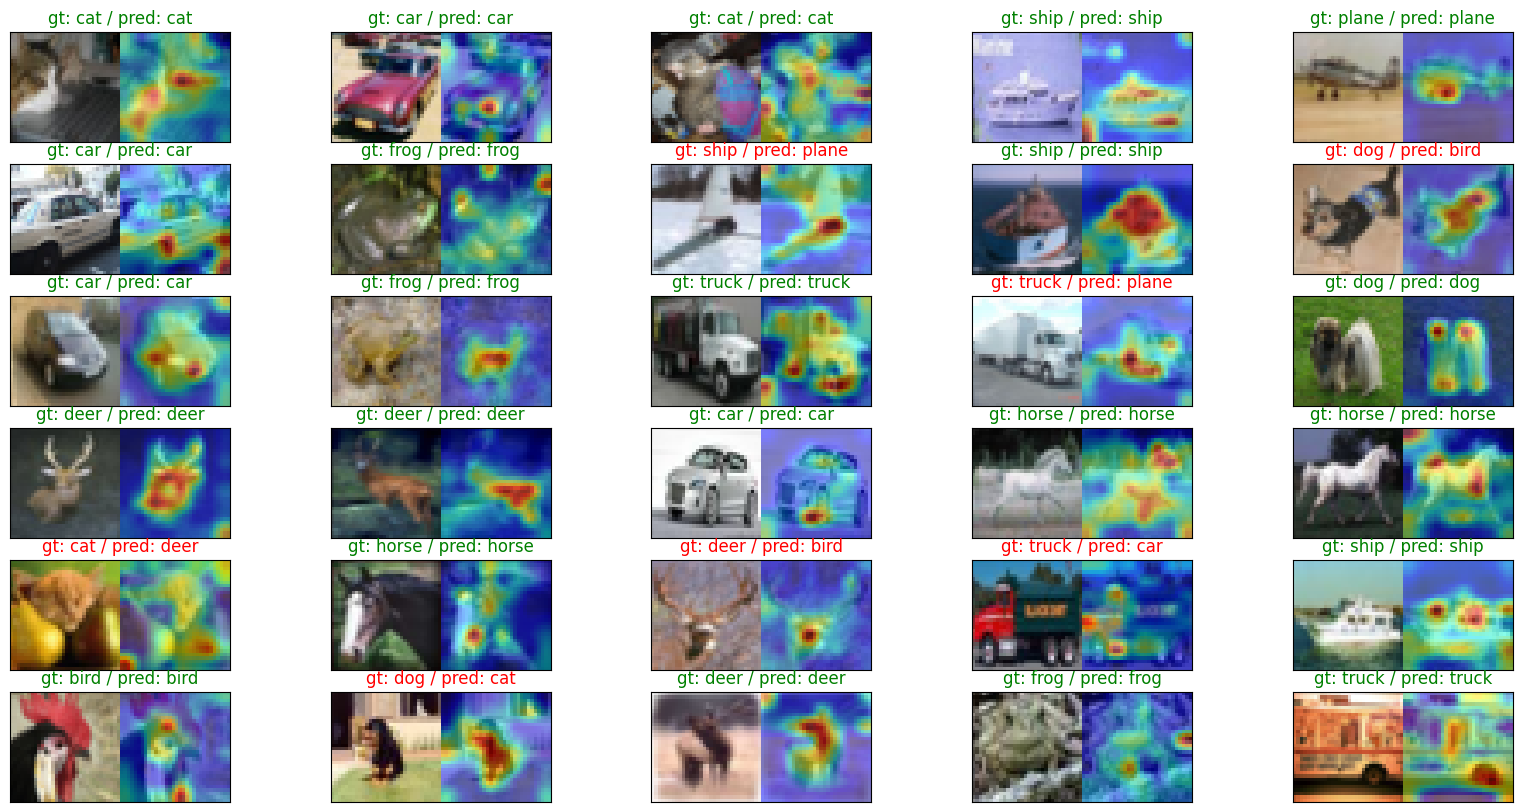

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### WITH SGD ###

In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'SGD #@param {type:"string"}'
batch_size = 256 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.01  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 2.3008, Test loss: 2.2984, Accuracy: 0.1826
Epoch: 2, Train loss: 2.2917, Test loss: 2.2787, Accuracy: 0.1802
Epoch: 3, Train loss: 2.2411, Test loss: 2.1874, Accuracy: 0.1749
Epoch: 4, Train loss: 2.1371, Test loss: 2.1034, Accuracy: 0.1833
Epoch: 5, Train loss: 2.0814, Test loss: 2.0868, Accuracy: 0.1903
Epoch: 6, Train loss: 2.0588, Test loss: 2.0734, Accuracy: 0.1900
Epoch: 7, Train loss: 2.0440, Test loss: 2.0405, Accuracy: 0.2036
Epoch: 8, Train loss: 2.0340, Test loss: 2.0414, Accuracy: 0.1997
Epoch: 9, Train loss: 2.0283, Test loss: 2.0538, Accuracy: 0.1977
Epoch: 10, Train loss: 2.0189, Test loss: 2.0443, Accuracy: 0.2050
Epoch: 11, Train loss: 2.0165, Test loss: 2.0423, Accuracy: 0.2131
Epoch: 12, Train loss: 2.0122, Test loss: 2.0222, Accuracy: 0.2121
Epoch: 13, Train loss: 2.0086, Test loss: 2.0186, Accuracy: 0.2240
Epoch: 14, Train loss: 2.0029, Test loss: 2.0079, Accuracy: 0.2272
Epoch: 15, Train loss: 1.9963, Test loss: 2.0001, Accuracy: 0.2317
Epoc

Files already downloaded and verified


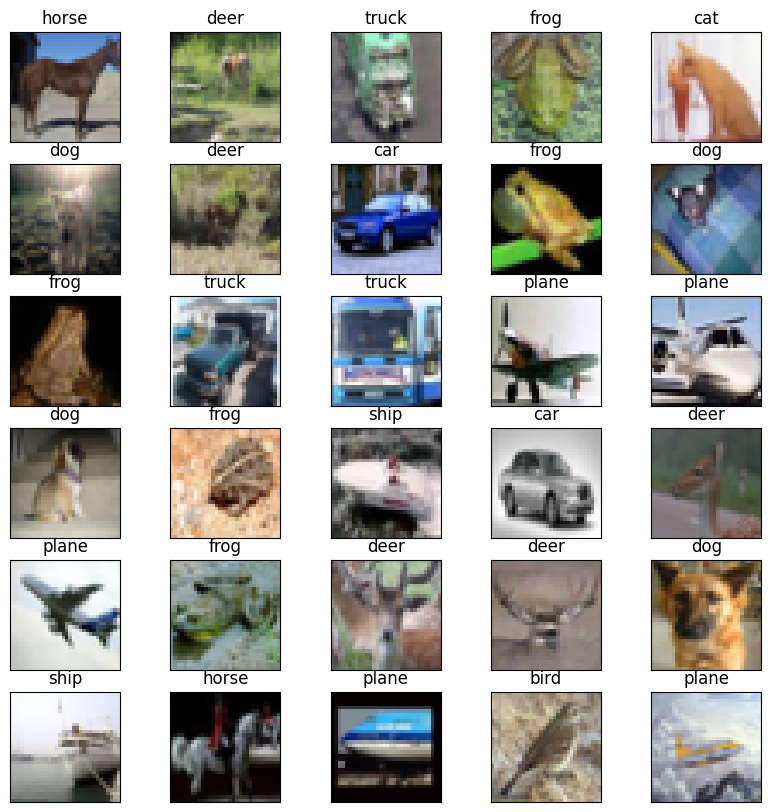

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

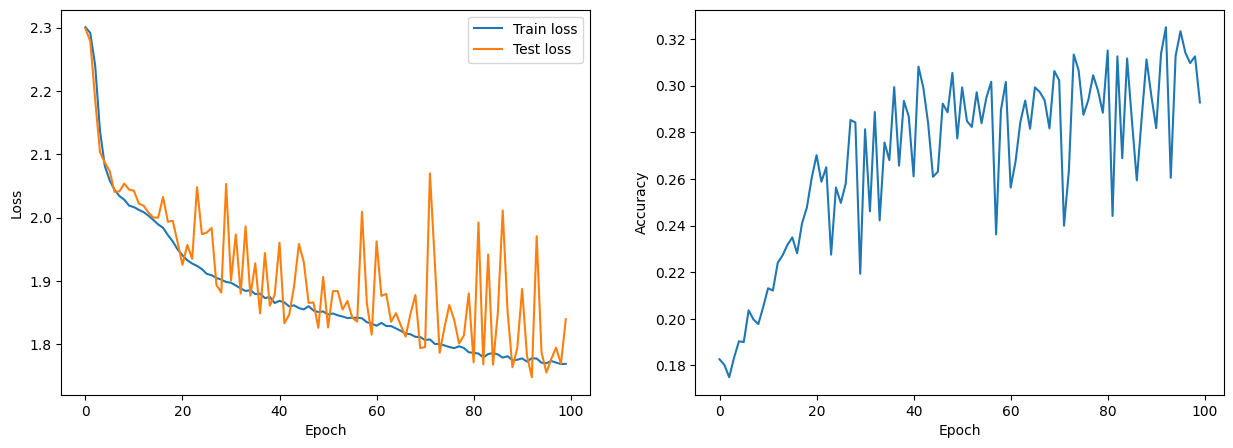

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


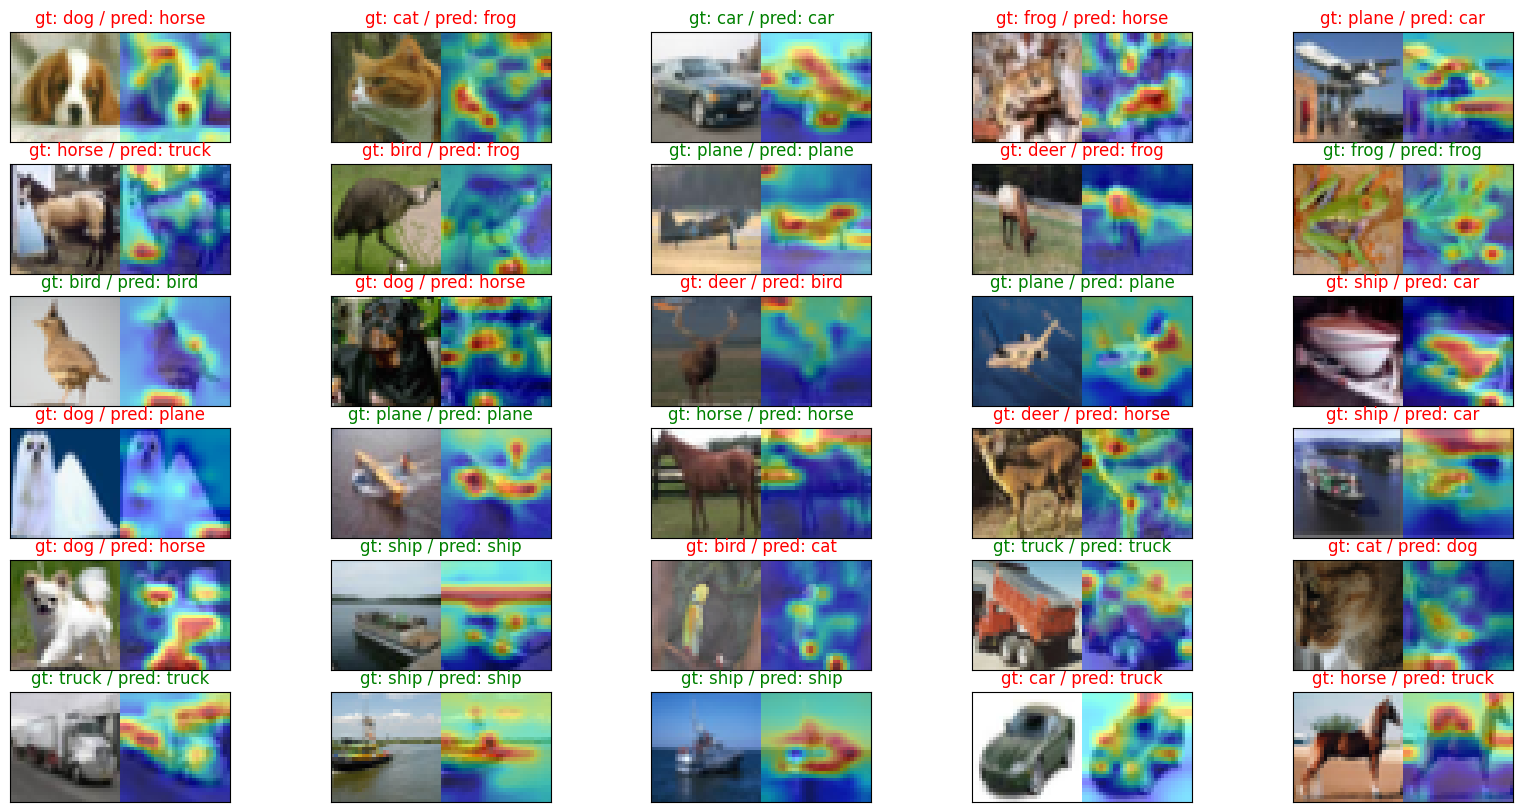

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### SGD 2 ###

In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'SGD #@param {type:"string"}'
batch_size = 256 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.005  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 12,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train loss: 2.2974, Test loss: 2.2896, Accuracy: 0.1794
Epoch: 2, Train loss: 2.2724, Test loss: 2.2431, Accuracy: 0.1770
Epoch: 3, Train loss: 2.1968, Test loss: 2.1479, Accuracy: 0.1777
Epoch: 4, Train loss: 2.1148, Test loss: 2.0908, Accuracy: 0.1870
Epoch: 5, Train loss: 2.0758, Test loss: 2.0942, Accuracy: 0.1932
Epoch: 6, Train loss: 2.0568, Test loss: 2.1112, Accuracy: 0.1932
Epoch: 7, Train loss: 2.0430, Test loss: 2.0561, Accuracy: 0.2071
Epoch: 8, Train loss: 2.0314, Test loss: 2.0398, Accuracy: 0.2109
Epoch: 9, Train loss: 2.0202, Test loss: 2.0583, Accuracy: 0.2061
Epoch: 10, Train loss: 2.0134, Test loss: 2.0620, Accuracy: 0.1985
Epoch: 11, Train loss: 2.0059, Test loss: 2.0213, Accuracy: 0.2167
Epoch: 12, Train loss: 1.9940, Test loss: 2.0113, Accuracy: 0.2286
Epoch: 13, Train loss: 1.9830, Test loss: 2.0301, Accuracy: 0.2265
Epoch: 14, Train loss: 1.9736, Test loss: 2.0723, Accuracy: 0.

Files already downloaded and verified


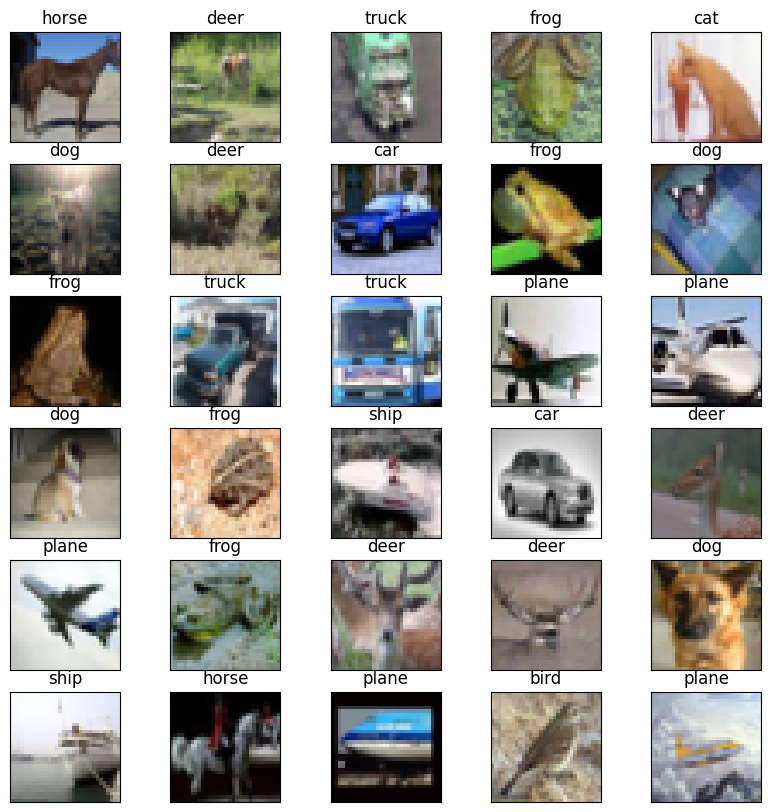

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

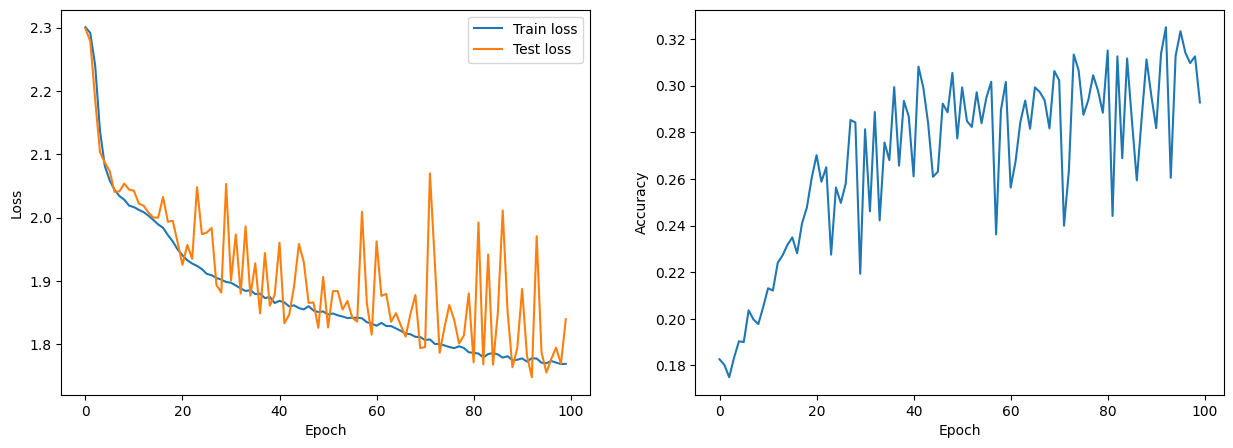

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


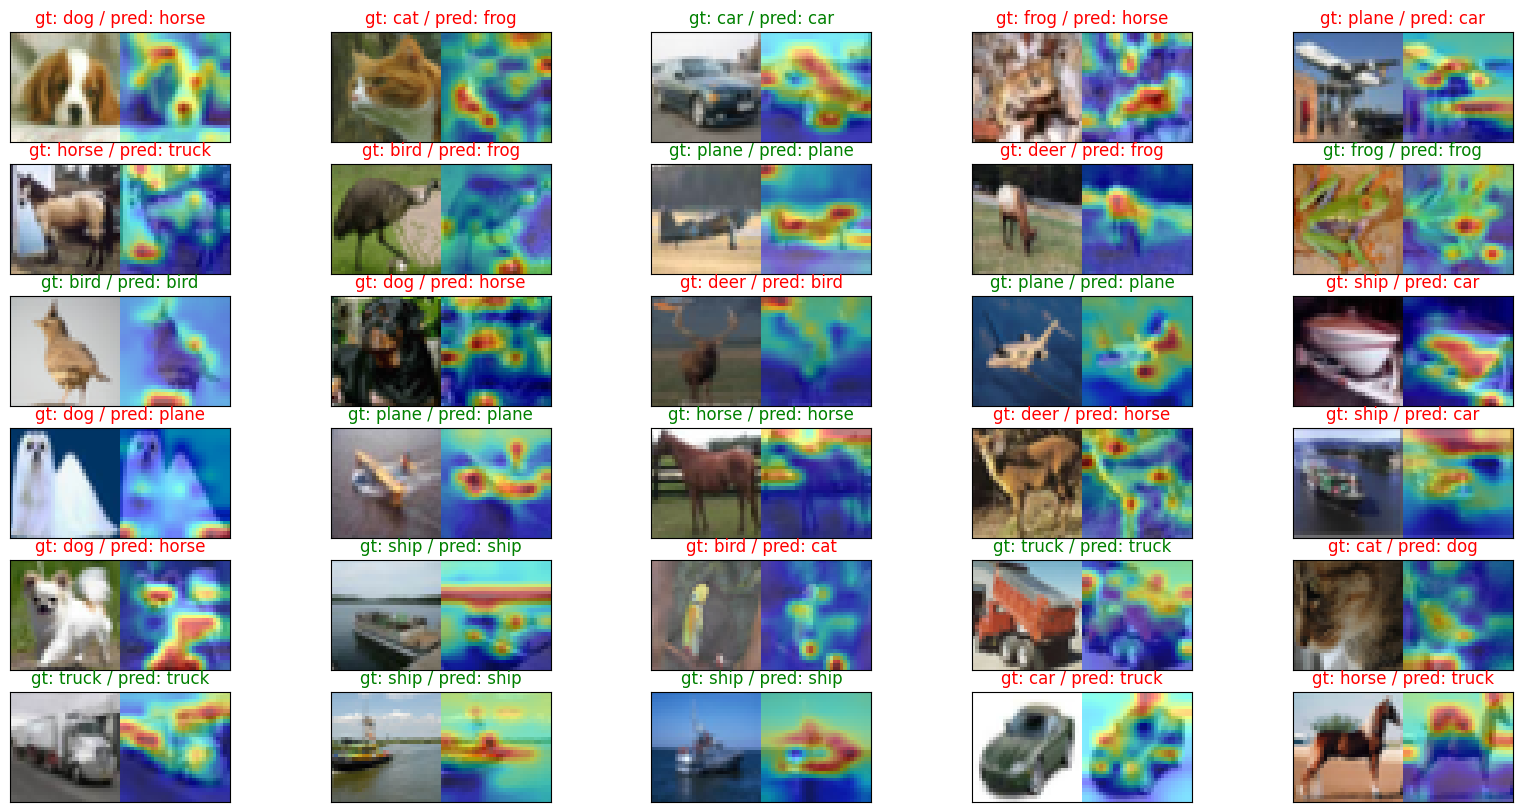

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### EXPERIMENT 1 ###


In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 256 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.01  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 12,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.9341, Test loss: 1.7213, Accuracy: 0.3649
Epoch: 2, Train loss: 1.6211, Test loss: 1.5904, Accuracy: 0.4278
Epoch: 3, Train loss: 1.4879, Test loss: 1.4874, Accuracy: 0.4708
Epoch: 4, Train loss: 1.3838, Test loss: 1.3085, Accuracy: 0.5264
Epoch: 5, Train loss: 1.3146, Test loss: 1.2915, Accuracy: 0.5288
Epoch: 6, Train loss: 1.2686, Test loss: 1.2745, Accuracy: 0.5379
Epoch: 7, Train loss: 1.2257, Test loss: 1.1922, Accuracy: 0.5610
Epoch: 8, Train loss: 1.1865, Test loss: 1.2107, Accuracy: 0.5682
Epoch: 9, Train loss: 1.1511, Test loss: 1.1888, Accuracy: 0.5762
Epoch: 10, Train loss: 1.1074, Test loss: 1.1023, Accuracy: 0.6060
Epoch: 11, Train loss: 1.0898, Test loss: 1.1378, Accuracy: 0.5967
Epoch: 12, Train loss: 1.0509, Test loss: 1.0566, Accuracy: 0.6204
Epoch: 13, Train loss: 1.0294, Test loss: 1.0704, Accuracy: 0.6146
Epoch: 14, Train loss: 1.0118, Test loss: 1.0825, Accuracy: 0.6165
Epoch: 15, Train loss: 0.9788, Test loss: 1.0379, Accuracy: 0.6241
Epoc

Files already downloaded and verified


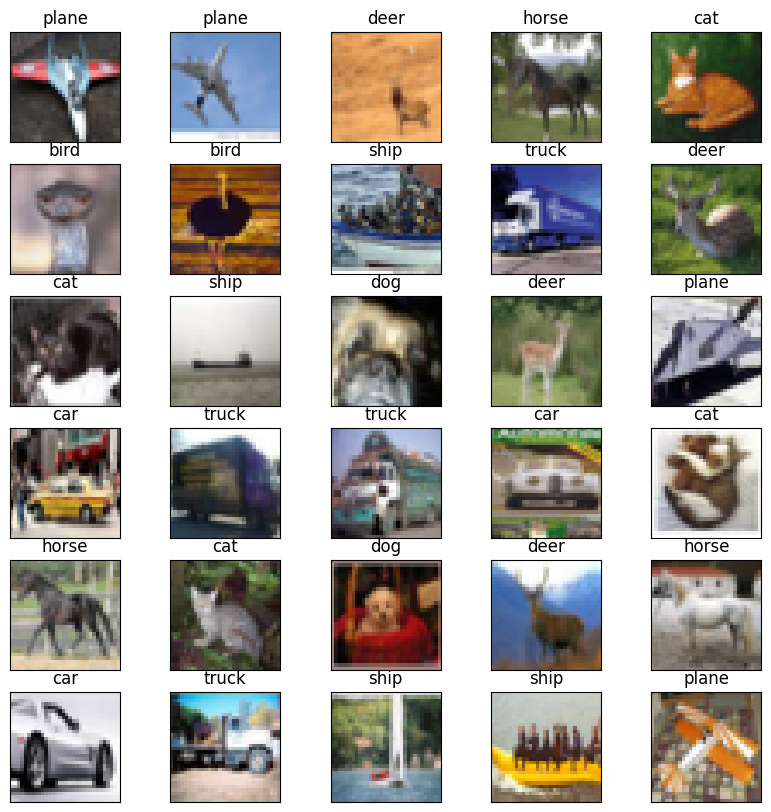

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### EXPERIMENT 2 ###


In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 256 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.005  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 12,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.9290, Test loss: 1.7244, Accuracy: 0.3534
Epoch: 2, Train loss: 1.6391, Test loss: 1.5263, Accuracy: 0.4485
Epoch: 3, Train loss: 1.4720, Test loss: 1.4091, Accuracy: 0.4918
Epoch: 4, Train loss: 1.3978, Test loss: 1.3354, Accuracy: 0.5140
Epoch: 5, Train loss: 1.3359, Test loss: 1.3063, Accuracy: 0.5295
Epoch: 6, Train loss: 1.2953, Test loss: 1.2601, Accuracy: 0.5441
Epoch: 7, Train loss: 1.2431, Test loss: 1.2394, Accuracy: 0.5543
Epoch: 8, Train loss: 1.2125, Test loss: 1.1721, Accuracy: 0.5793
Epoch: 9, Train loss: 1.1620, Test loss: 1.1568, Accuracy: 0.5872
Epoch: 10, Train loss: 1.1343, Test loss: 1.1178, Accuracy: 0.5973
Epoch: 11, Train loss: 1.0998, Test loss: 1.1377, Accuracy: 0.5966
Epoch: 12, Train loss: 1.0703, Test loss: 1.0748, Accuracy: 0.6177
Epoch: 13, Train loss: 1.0457, Test loss: 1.0923, Accuracy: 0.6152
Epoch: 14, Train loss: 1.0116, Test loss: 1.0608, Accuracy: 0.6187
Epoch: 15, Train loss: 0.9862, Test loss: 1.0542, Accuracy: 0.6200
Epoc

Files already downloaded and verified


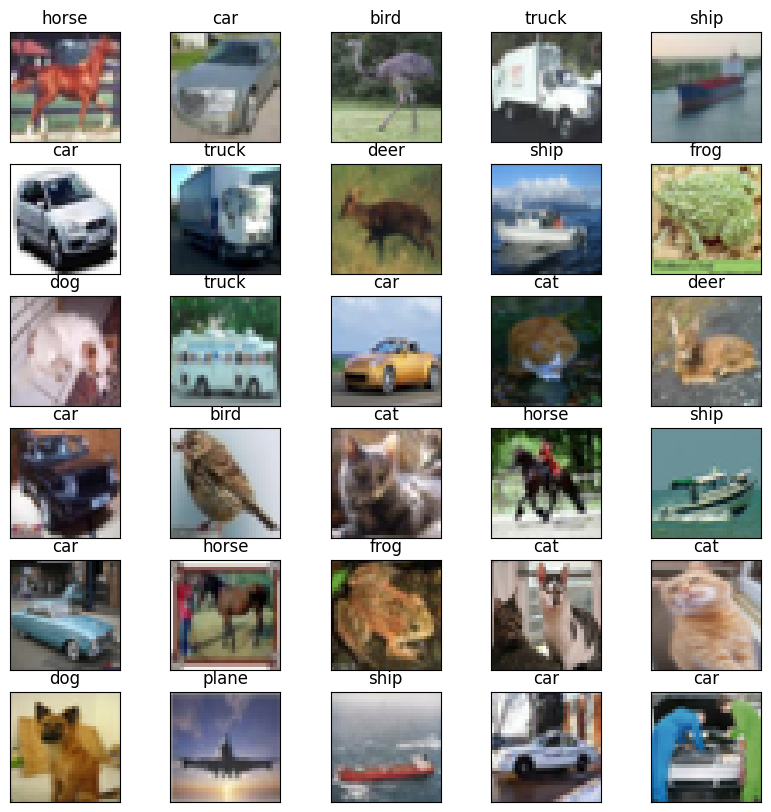

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

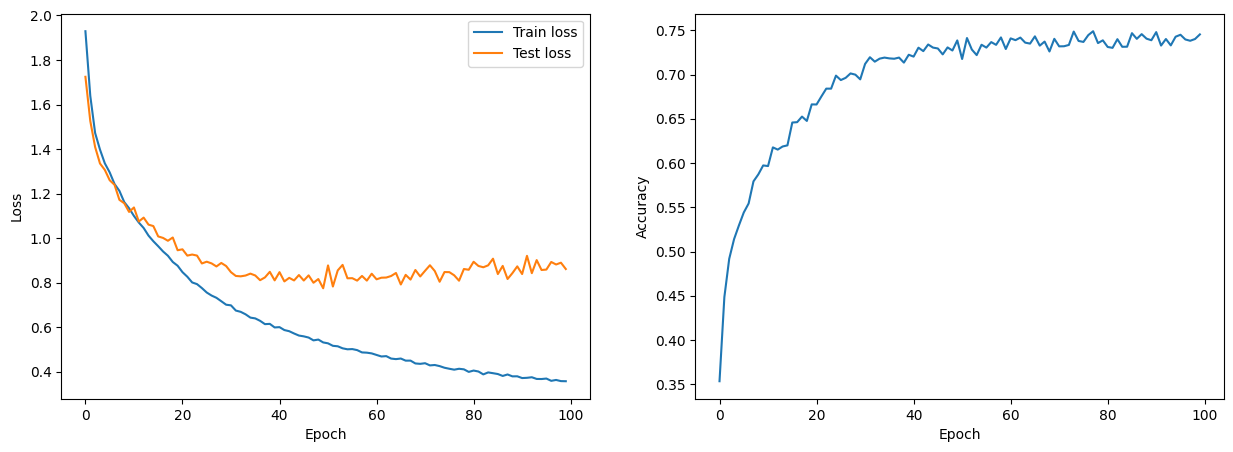

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


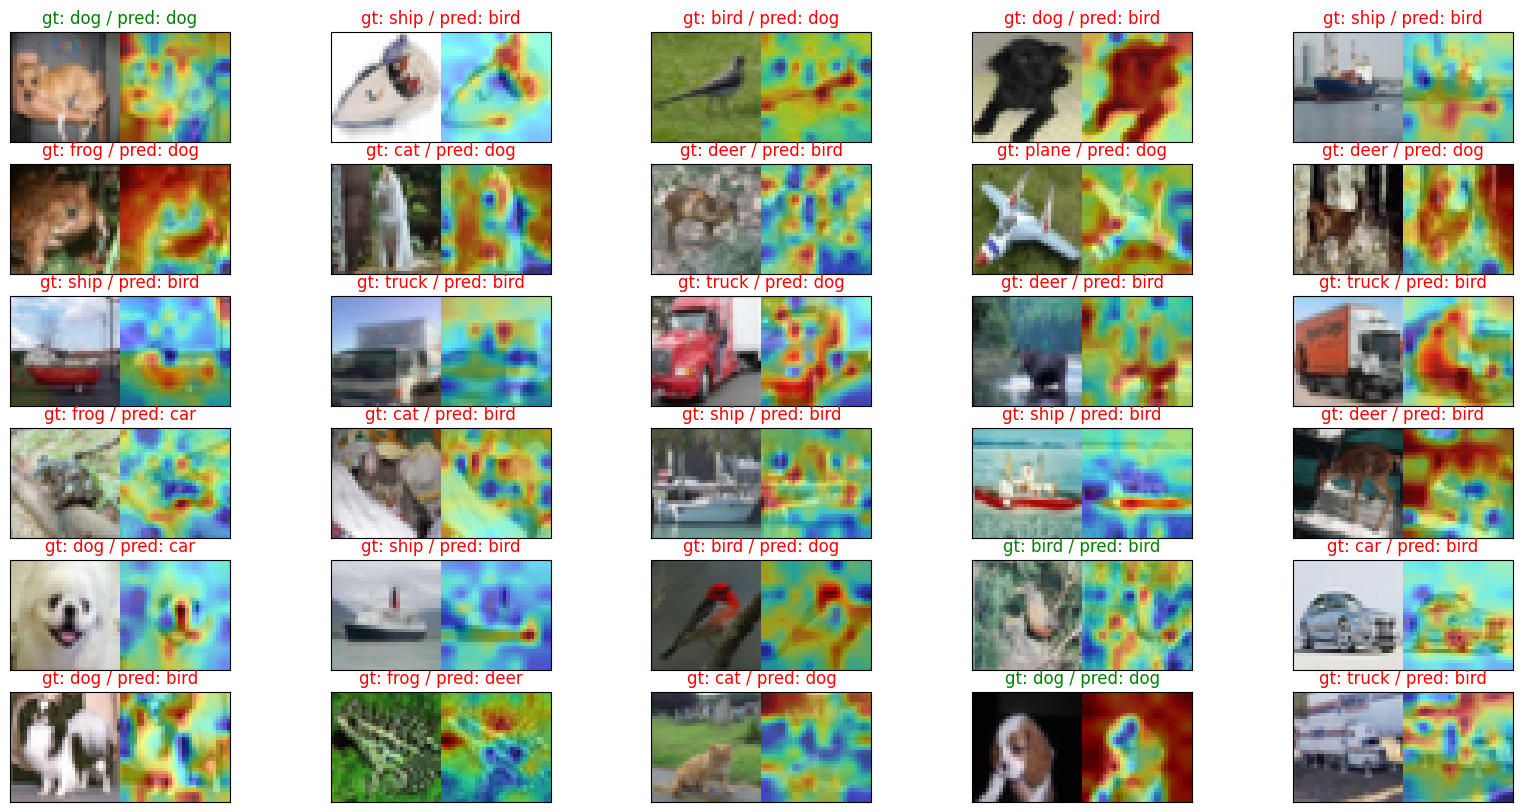

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### EXPERIMENT 3 ###


In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 128 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.005  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 12,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


100%|██████████| 170498071/170498071 [00:05<00:00, 28857474.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.8635, Test loss: 1.6656, Accuracy: 0.3844
Epoch: 2, Train loss: 1.5730, Test loss: 1.4662, Accuracy: 0.4631
Epoch: 3, Train loss: 1.4570, Test loss: 1.3799, Accuracy: 0.5015
Epoch: 4, Train loss: 1.3902, Test loss: 1.3495, Accuracy: 0.5141
Epoch: 5, Train loss: 1.3351, Test loss: 1.3011, Accuracy: 0.5279
Epoch: 6, Train loss: 1.2917, Test loss: 1.2759, Accuracy: 0.5372
Epoch: 7, Train loss: 1.2526, Test loss: 1.2028, Accuracy: 0.5623
Epoch: 8, Train loss: 1.2177, Test loss: 1.1987, Accuracy: 0.5665
Epoch: 9, Train loss: 1.1801, Test loss: 1.1690, Accuracy: 0.5813
Epoch: 10, Train loss: 1.1537, Test loss: 1.1738, Accuracy: 0.5789
Epoch: 11, Train loss: 1.1274, Test loss: 1.1579, Accuracy: 0.5853
Epoch: 12, Train loss: 1.0921, Test loss: 1.1014, Accuracy: 0.6087
Epoch: 13, Train loss: 1.0666, Test loss: 1.1127, Accuracy: 0.5990
Epoch: 14, Train loss: 1.0396, Test loss: 1.0817, Accuracy: 0.6147
Epoch: 15, Train loss: 1.0212, Test loss: 1.0205, Accuracy: 0.6360
Epoc

Files already downloaded and verified


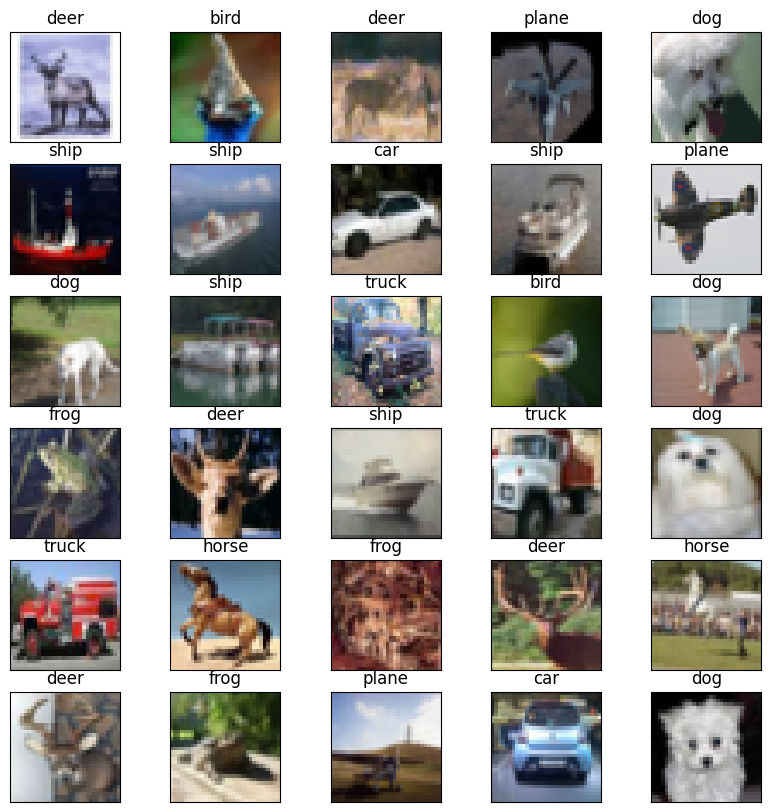

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

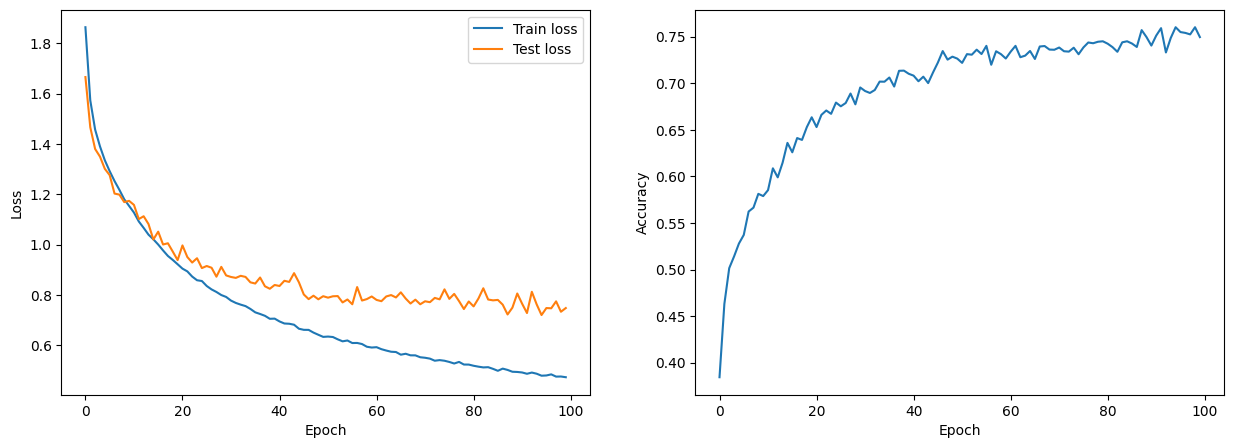

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


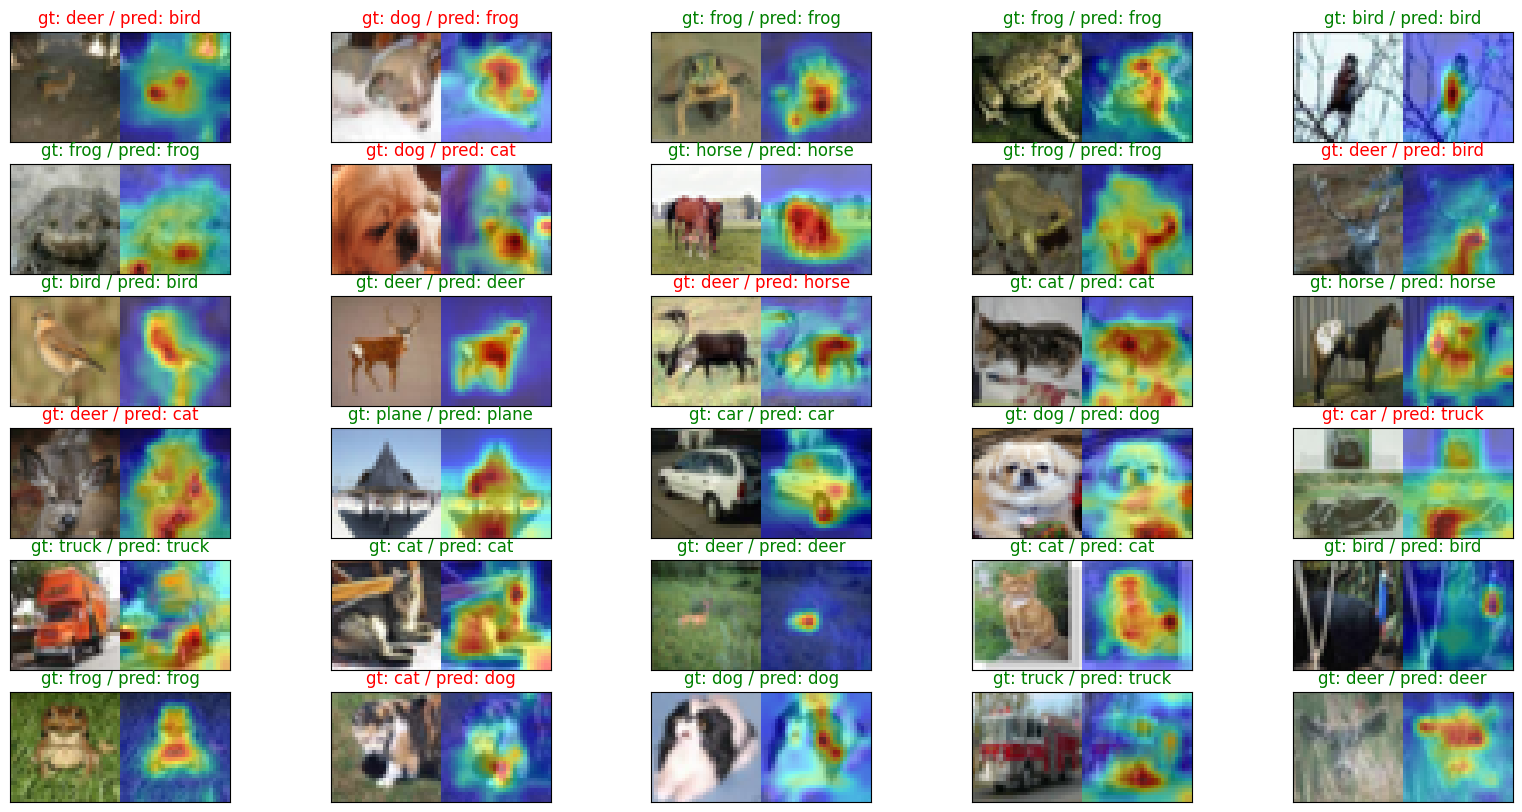

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### EXPERIMENT 3 ###


In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 128 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.005  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 12,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


100%|██████████| 170498071/170498071 [00:05<00:00, 28857474.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.8635, Test loss: 1.6656, Accuracy: 0.3844
Epoch: 2, Train loss: 1.5730, Test loss: 1.4662, Accuracy: 0.4631
Epoch: 3, Train loss: 1.4570, Test loss: 1.3799, Accuracy: 0.5015
Epoch: 4, Train loss: 1.3902, Test loss: 1.3495, Accuracy: 0.5141
Epoch: 5, Train loss: 1.3351, Test loss: 1.3011, Accuracy: 0.5279
Epoch: 6, Train loss: 1.2917, Test loss: 1.2759, Accuracy: 0.5372
Epoch: 7, Train loss: 1.2526, Test loss: 1.2028, Accuracy: 0.5623
Epoch: 8, Train loss: 1.2177, Test loss: 1.1987, Accuracy: 0.5665
Epoch: 9, Train loss: 1.1801, Test loss: 1.1690, Accuracy: 0.5813
Epoch: 10, Train loss: 1.1537, Test loss: 1.1738, Accuracy: 0.5789
Epoch: 11, Train loss: 1.1274, Test loss: 1.1579, Accuracy: 0.5853
Epoch: 12, Train loss: 1.0921, Test loss: 1.1014, Accuracy: 0.6087
Epoch: 13, Train loss: 1.0666, Test loss: 1.1127, Accuracy: 0.5990
Epoch: 14, Train loss: 1.0396, Test loss: 1.0817, Accuracy: 0.6147
Epoch: 15, Train loss: 1.0212, Test loss: 1.0205, Accuracy: 0.6360
Epoc

Files already downloaded and verified


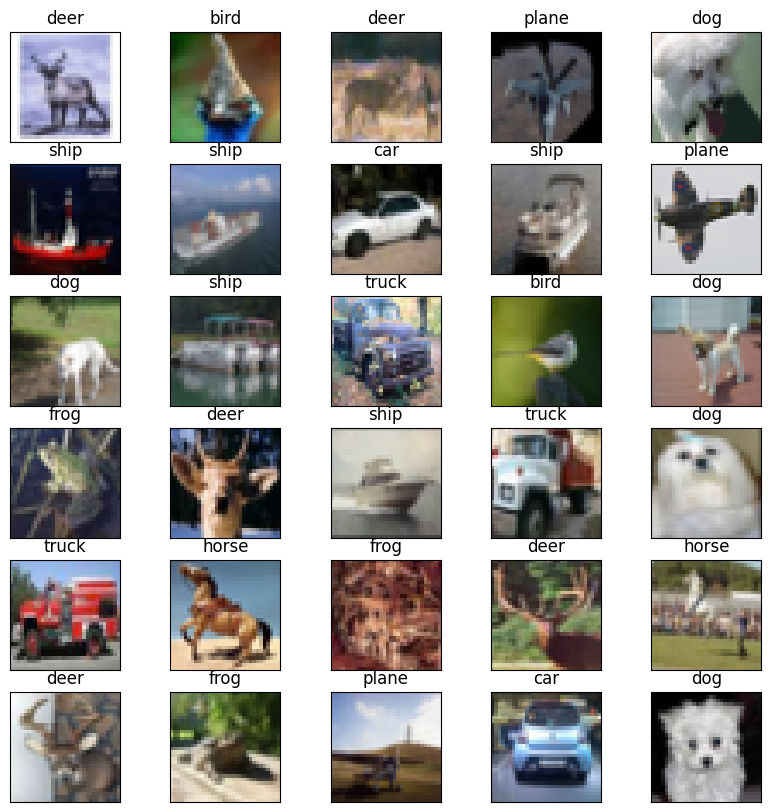

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

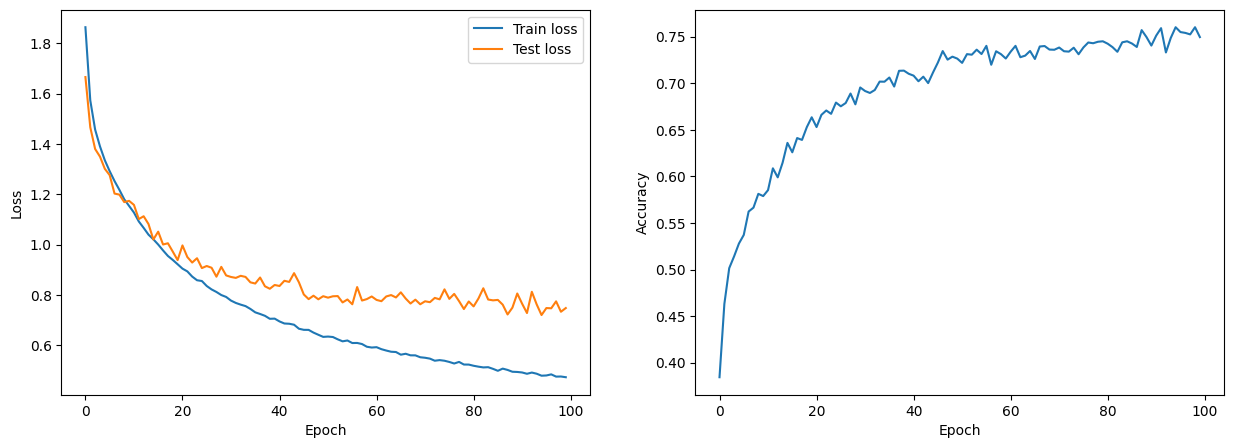

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


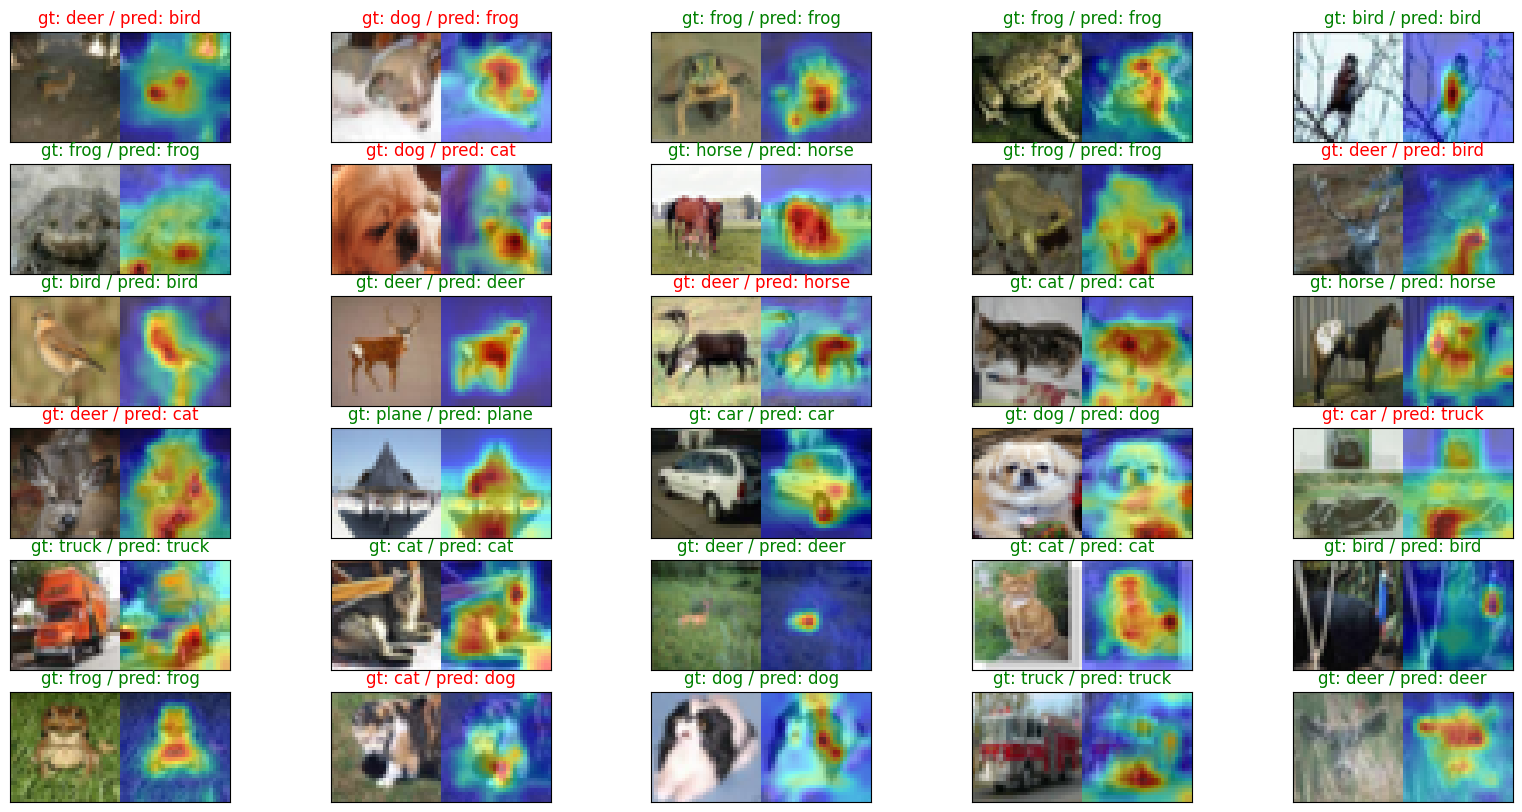

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

### EXPERIMENT 4 ###


In [ ]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 128 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 0.0005  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 12,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train loss: 1.9321, Test loss: 1.7832, Accuracy: 0.3338
Epoch: 2, Train loss: 1.7000, Test loss: 1.6442, Accuracy: 0.3813
Epoch: 3, Train loss: 1.5857, Test loss: 1.4689, Accuracy: 0.4649
Epoch: 4, Train loss: 1.4672, Test loss: 1.3973, Accuracy: 0.4874
Epoch: 5, Train loss: 1.3896, Test loss: 1.3501, Accuracy: 0.5054
Epoch: 6, Train loss: 1.3276, Test loss: 1.3121, Accuracy: 0.5261
Epoch: 7, Train loss: 1.2795, Test loss: 1.3105, Accuracy: 0.5292
Epoch: 8, Train loss: 1.2420, Test loss: 1.2214, Accuracy: 0.5601
Epoch: 9, Train loss: 1.2022, Test loss: 1.1948, Accuracy: 0.5640
Epoch: 10, Train loss: 1.1745, Test loss: 1.1844, Accuracy: 0.5682
Epoch: 11, Train loss: 1.1355, Test loss: 1.1540, Accuracy: 0.5857
Epoch: 12, Train loss: 1.1094, Test loss: 1.1258, Accuracy: 0.5972
Epoch: 13, Train loss: 1.0746, Test loss: 1.0966, Accuracy: 0.6074
Epoch: 14, Train loss: 1.0478, Test loss: 1.0229, Accuracy: 0.

Files already downloaded and verified


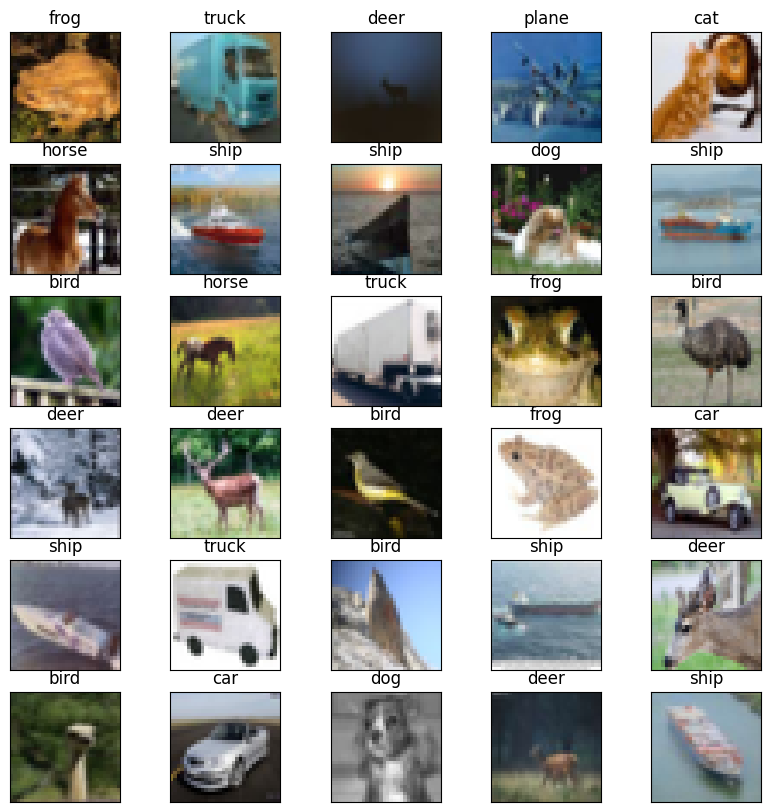

In [ ]:
#@title Visualize Dataset
# Show some training images
visualize_images()

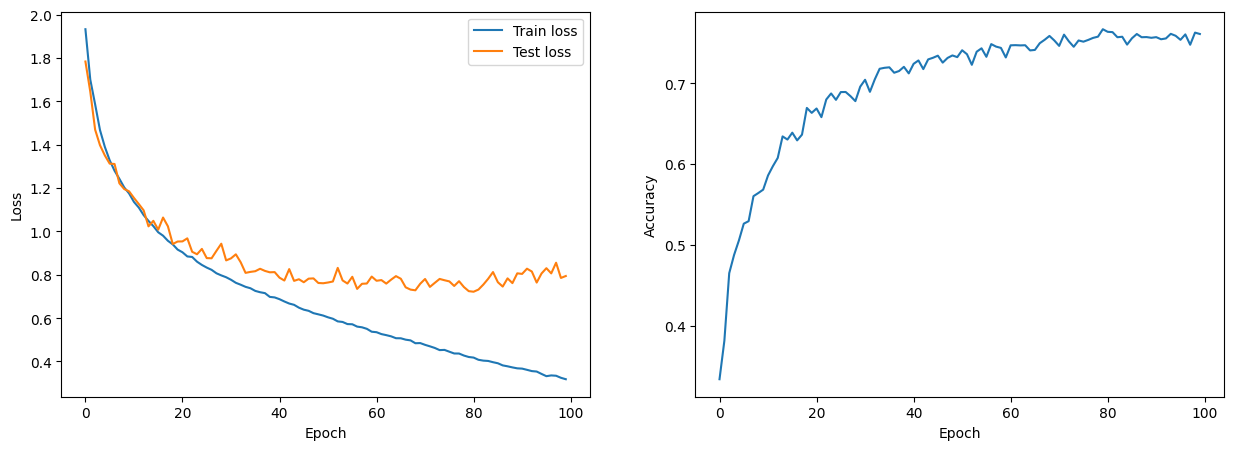

In [ ]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


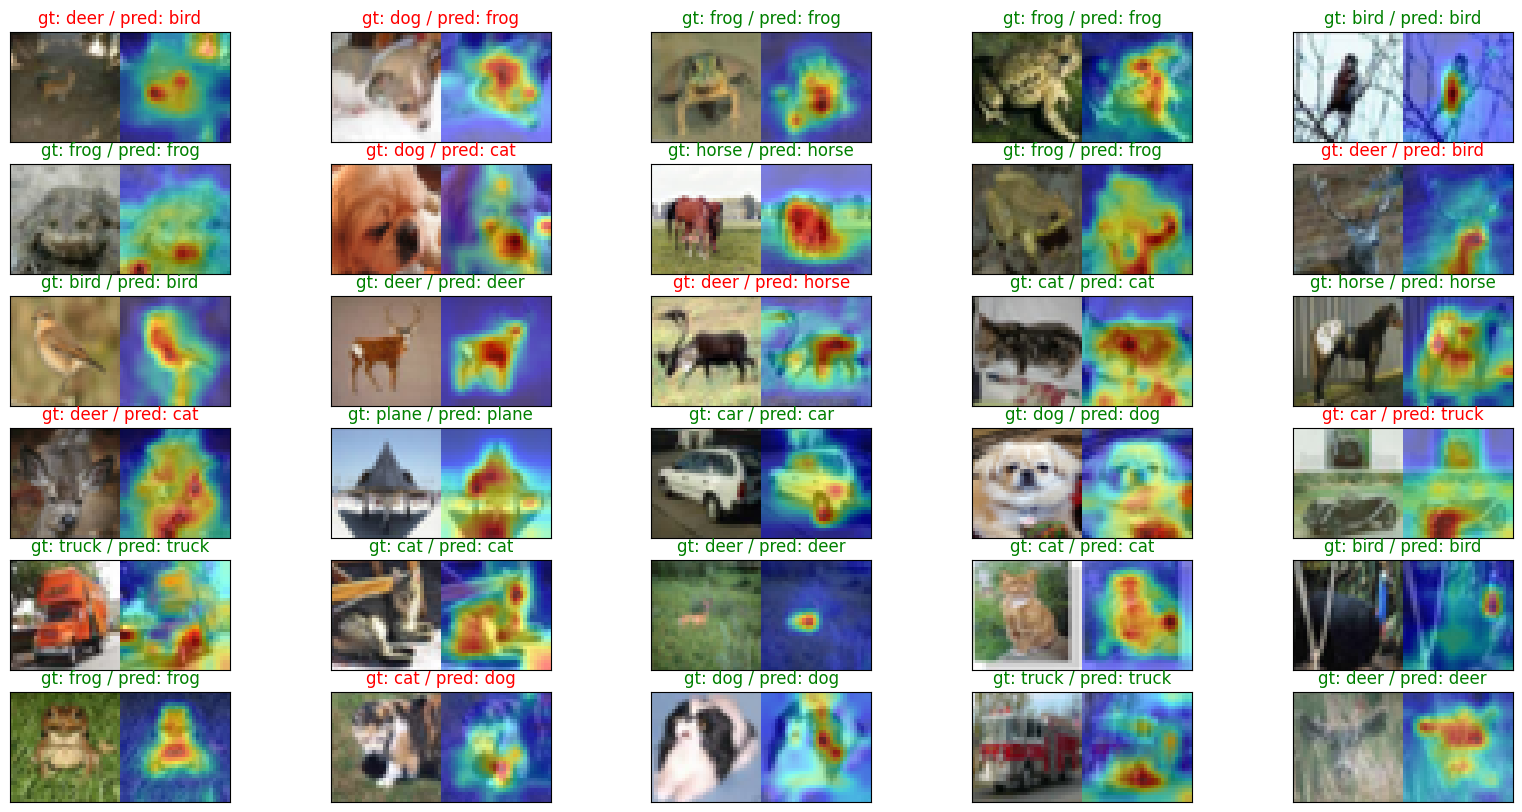

In [ ]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")

In [ ]:
#@title Setup and Model Definitions
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

# Reusing the previously defined classes like ViTForClassfication, Trainer, etc.
# Ensure you've defined all those before this block or include them again here.

#@title Prepare Data for Fashion MNIST
def prepare_fashion_mnist_data(batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),  # Resize to conform with the ViT input
        transforms.Normalize((0.5,), (0.5,))  # Normalizing for grayscale
    ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    return trainloader, testloader

In [ ]:


#@title Fine-Tuning the ViT Model
def fine_tune_ViT():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 256
    epochs = 50
    lr = 0.001

    # Config adapted for grayscale images
    config = {
        "patch_size": 4,
        "hidden_size": 48,
        "num_hidden_layers": 4,
        "num_attention_heads": 4,
        "intermediate_size": 4 * 48,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,  # 10 classes in Fashion MNIST
        "num_channels": 1,  # Grayscale images
        "qkv_bias": True,
        "use_faster_attention": True,
    }

    # Prepare data
    trainloader, testloader = prepare_fashion_mnist_data(batch_size)

    # Model, optimizer, and loss function
    model = ViTForClassfication(config)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Trainer
    trainer = Trainer(model, optimizer, loss_fn, "vit-fashion-mnist", device)
    trainer.train(trainloader, testloader, epochs)

if __name__ == '__main__':
    fine_tune_ViT()


Epoch: 1, Train loss: 1.5259, Test loss: 1.0030, Accuracy: 0.6007
Epoch: 2, Train loss: 0.8569, Test loss: 0.7264, Accuracy: 0.7346
Epoch: 3, Train loss: 0.6915, Test loss: 0.6170, Accuracy: 0.7726
Epoch: 4, Train loss: 0.6104, Test loss: 0.5878, Accuracy: 0.7834
Epoch: 5, Train loss: 0.5646, Test loss: 0.5430, Accuracy: 0.8024
Epoch: 6, Train loss: 0.5410, Test loss: 0.5157, Accuracy: 0.8137
Epoch: 7, Train loss: 0.5156, Test loss: 0.5300, Accuracy: 0.8126
Epoch: 8, Train loss: 0.4963, Test loss: 0.4767, Accuracy: 0.8283
Epoch: 9, Train loss: 0.4870, Test loss: 0.4575, Accuracy: 0.8322
Epoch: 10, Train loss: 0.4717, Test loss: 0.4413, Accuracy: 0.8405
Epoch: 11, Train loss: 0.4579, Test loss: 0.4805, Accuracy: 0.8261
Epoch: 12, Train loss: 0.4533, Test loss: 0.4672, Accuracy: 0.8286
Epoch: 13, Train loss: 0.4434, Test loss: 0.4604, Accuracy: 0.8341
Epoch: 14, Train loss: 0.4366, Test loss: 0.4168, Accuracy: 0.8468
Epoch: 15, Train loss: 0.4326, Test loss: 0.4302, Accuracy: 0.8446
Epoc

In [ ]:


#@title Fine-Tuning the ViT Model
def fine_tune_ViT():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 256
    epochs = 50
    lr = 0.0001

    # Config adapted for grayscale images
    config = {
        "patch_size": 4,
        "hidden_size": 48,
        "num_hidden_layers": 4,
        "num_attention_heads": 4,
        "intermediate_size": 4 * 48,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,  # 10 classes in Fashion MNIST
        "num_channels": 1,  # Grayscale images
        "qkv_bias": True,
        "use_faster_attention": True,
    }

    # Prepare data
    trainloader, testloader = prepare_fashion_mnist_data(batch_size)

    # Model, optimizer, and loss function
    model = ViTForClassfication(config)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Trainer
    trainer = Trainer(model, optimizer, loss_fn, "vit-fashion-mnist", device)
    trainer.train(trainloader, testloader, epochs)

if __name__ == '__main__':
    fine_tune_ViT()


Epoch: 1, Train loss: 1.9701, Test loss: 1.6502, Accuracy: 0.3283
Epoch: 2, Train loss: 1.5010, Test loss: 1.3875, Accuracy: 0.4803
Epoch: 3, Train loss: 1.2138, Test loss: 1.2198, Accuracy: 0.5486
Epoch: 4, Train loss: 1.0364, Test loss: 1.0489, Accuracy: 0.6009
Epoch: 5, Train loss: 0.9396, Test loss: 0.9388, Accuracy: 0.6228
Epoch: 6, Train loss: 0.8584, Test loss: 0.8491, Accuracy: 0.6758
Epoch: 7, Train loss: 0.8184, Test loss: 0.7947, Accuracy: 0.6758
Epoch: 8, Train loss: 0.7772, Test loss: 0.7689, Accuracy: 0.7020
Epoch: 9, Train loss: 0.7443, Test loss: 0.7061, Accuracy: 0.7193
Epoch: 10, Train loss: 0.7091, Test loss: 0.6730, Accuracy: 0.7444
Epoch: 11, Train loss: 0.6800, Test loss: 0.6534, Accuracy: 0.7537
Epoch: 12, Train loss: 0.6700, Test loss: 0.6197, Accuracy: 0.7654
Epoch: 13, Train loss: 0.6414, Test loss: 0.6137, Accuracy: 0.7702
Epoch: 14, Train loss: 0.6305, Test loss: 0.6139, Accuracy: 0.7686
Epoch: 15, Train loss: 0.6186, Test loss: 0.5727, Accuracy: 0.7836
Epoc

### STL - 10 ###

In [ ]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Assuming ViTForClassfication and Trainer classes are defined above

def prepare_stl10_data(batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to fit the input size of ViT which is typically larger
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Downloading and loading the STL-10 dataset
    trainset = torchvision.datasets.STL10(root='./data', split='train',
                                          download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.STL10(root='./data', split='test',
                                         download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers)

    return trainloader, testloader

In [ ]:
#@title Setup and Model Definitions
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

# Reusing the previously defined classes like ViTForClassfication, Trainer, etc.
# Ensure you've defined all those before this block or include them again here.

#@title Prepare Data for Fashion MNIST
def prepare_fashion_mnist_data(batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),  # Resize to conform with the ViT input
        transforms.Normalize((0.5,), (0.5,))  # Normalizing for grayscale
    ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    return trainloader, testloader

In [ ]:


#@title Fine-Tuning the ViT Model
def fine_tune_ViT():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 256
    epochs = 50
    lr = 0.001

    # Config adapted for grayscale images
    config = {
        "patch_size": 4,
        "hidden_size": 48,
        "num_hidden_layers": 4,
        "num_attention_heads": 4,
        "intermediate_size": 4 * 48,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,  # 10 classes in Fashion MNIST
        "num_channels": 1,  # Grayscale images
        "qkv_bias": True,
        "use_faster_attention": True,
    }

    # Prepare data
    trainloader, testloader = prepare_fashion_mnist_data(batch_size)

    # Model, optimizer, and loss function
    model = ViTForClassfication(config)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Trainer
    trainer = Trainer(model, optimizer, loss_fn, "vit-fashion-mnist", device)
    trainer.train(trainloader, testloader, epochs)

if __name__ == '__main__':
    fine_tune_ViT()


Epoch: 1, Train loss: 1.5259, Test loss: 1.0030, Accuracy: 0.6007
Epoch: 2, Train loss: 0.8569, Test loss: 0.7264, Accuracy: 0.7346
Epoch: 3, Train loss: 0.6915, Test loss: 0.6170, Accuracy: 0.7726
Epoch: 4, Train loss: 0.6104, Test loss: 0.5878, Accuracy: 0.7834
Epoch: 5, Train loss: 0.5646, Test loss: 0.5430, Accuracy: 0.8024
Epoch: 6, Train loss: 0.5410, Test loss: 0.5157, Accuracy: 0.8137
Epoch: 7, Train loss: 0.5156, Test loss: 0.5300, Accuracy: 0.8126
Epoch: 8, Train loss: 0.4963, Test loss: 0.4767, Accuracy: 0.8283
Epoch: 9, Train loss: 0.4870, Test loss: 0.4575, Accuracy: 0.8322
Epoch: 10, Train loss: 0.4717, Test loss: 0.4413, Accuracy: 0.8405
Epoch: 11, Train loss: 0.4579, Test loss: 0.4805, Accuracy: 0.8261
Epoch: 12, Train loss: 0.4533, Test loss: 0.4672, Accuracy: 0.8286
Epoch: 13, Train loss: 0.4434, Test loss: 0.4604, Accuracy: 0.8341
Epoch: 14, Train loss: 0.4366, Test loss: 0.4168, Accuracy: 0.8468
Epoch: 15, Train loss: 0.4326, Test loss: 0.4302, Accuracy: 0.8446
Epoc

In [76]:
#@title Setup and Model Definitions
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

# Reusing the previously defined classes like ViTForClassfication, Trainer, etc.
# Ensure you've defined all those before this block or include them again here.

#@title Prepare Data for Fashion MNIST
def prepare_fashion_mnist_data(batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),  # Resize to conform with the ViT input
        transforms.Normalize((0.5,), (0.5,))  # Normalizing for grayscale
    ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    return trainloader, testloader

In [78]:


#@title Fine-Tuning the ViT Model
def fine_tune_ViT():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 32
    epochs = 50
    lr = 0.005

    # Config adapted for grayscale images
    config = {
        "patch_size": 4,
        "hidden_size": 48,
        "num_hidden_layers": 4,
        "num_attention_heads": 4,
        "intermediate_size": 4 * 48,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,  # 10 classes in Fashion MNIST
        "num_channels": 3,  # Grayscale images
        "qkv_bias": True,
        "use_faster_attention": True,
    }

    # Prepare data
    trainloader, testloader = prepare_fashion_mnist_data(batch_size)

    # Model, optimizer, and loss function
    model = ViTForClassfication(config)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Trainer
    trainer = Trainer(model, optimizer, loss_fn, "vit-fashion-mnist", device)
    trainer.train(trainloader, testloader, epochs)

if __name__ == '__main__':
    fine_tune_ViT()


Epoch: 1, Train loss: 0.9234, Test loss: 0.6199, Accuracy: 0.7730
Epoch: 2, Train loss: 0.6249, Test loss: 0.6745, Accuracy: 0.7513
Epoch: 3, Train loss: 0.5728, Test loss: 0.5614, Accuracy: 0.7935
Epoch: 4, Train loss: 0.5386, Test loss: 0.4946, Accuracy: 0.8217
Epoch: 5, Train loss: 0.5145, Test loss: 0.4712, Accuracy: 0.8325
Epoch: 6, Train loss: 0.4946, Test loss: 0.4881, Accuracy: 0.8282
Epoch: 7, Train loss: 0.4821, Test loss: 0.4338, Accuracy: 0.8424
Epoch: 8, Train loss: 0.4677, Test loss: 0.4527, Accuracy: 0.8345
Epoch: 9, Train loss: 0.4583, Test loss: 0.4735, Accuracy: 0.8355
Epoch: 10, Train loss: 0.4553, Test loss: 0.4084, Accuracy: 0.8510
Epoch: 11, Train loss: 0.4466, Test loss: 0.4350, Accuracy: 0.8437
Epoch: 12, Train loss: 0.4421, Test loss: 0.4475, Accuracy: 0.8480
Epoch: 13, Train loss: 0.4427, Test loss: 0.4299, Accuracy: 0.8510
Epoch: 14, Train loss: 0.4341, Test loss: 0.4310, Accuracy: 0.8453
Epoch: 15, Train loss: 0.4347, Test loss: 0.4034, Accuracy: 0.8526
Epoc

In [94]:
#@title Plot training Results
import matplotlib.pyplot as plt

# Call the load_experiment function with the appropriate experiment name
config, model, train_losses, test_losses, accuracies = load_experiment("vit-fashion-mnist")

# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(accuracies, label="Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.savefig("metrics.png")  # Save the figure in the current directory
plt.show()  # Display the plots


RuntimeError: Error(s) in loading state_dict for ViTForClassfication:
	Missing key(s) in state_dict: "encoder.blocks.4.attention.qkv_projection.weight", "encoder.blocks.4.attention.qkv_projection.bias", "encoder.blocks.4.attention.output_projection.weight", "encoder.blocks.4.attention.output_projection.bias", "encoder.blocks.4.layernorm_1.weight", "encoder.blocks.4.layernorm_1.bias", "encoder.blocks.4.mlp.dense_1.weight", "encoder.blocks.4.mlp.dense_1.bias", "encoder.blocks.4.mlp.dense_2.weight", "encoder.blocks.4.mlp.dense_2.bias", "encoder.blocks.4.layernorm_2.weight", "encoder.blocks.4.layernorm_2.bias", "encoder.blocks.5.attention.qkv_projection.weight", "encoder.blocks.5.attention.qkv_projection.bias", "encoder.blocks.5.attention.output_projection.weight", "encoder.blocks.5.attention.output_projection.bias", "encoder.blocks.5.layernorm_1.weight", "encoder.blocks.5.layernorm_1.bias", "encoder.blocks.5.mlp.dense_1.weight", "encoder.blocks.5.mlp.dense_1.bias", "encoder.blocks.5.mlp.dense_2.weight", "encoder.blocks.5.mlp.dense_2.bias", "encoder.blocks.5.layernorm_2.weight", "encoder.blocks.5.layernorm_2.bias", "encoder.blocks.6.attention.qkv_projection.weight", "encoder.blocks.6.attention.qkv_projection.bias", "encoder.blocks.6.attention.output_projection.weight", "encoder.blocks.6.attention.output_projection.bias", "encoder.blocks.6.layernorm_1.weight", "encoder.blocks.6.layernorm_1.bias", "encoder.blocks.6.mlp.dense_1.weight", "encoder.blocks.6.mlp.dense_1.bias", "encoder.blocks.6.mlp.dense_2.weight", "encoder.blocks.6.mlp.dense_2.bias", "encoder.blocks.6.layernorm_2.weight", "encoder.blocks.6.layernorm_2.bias", "encoder.blocks.7.attention.qkv_projection.weight", "encoder.blocks.7.attention.qkv_projection.bias", "encoder.blocks.7.attention.output_projection.weight", "encoder.blocks.7.attention.output_projection.bias", "encoder.blocks.7.layernorm_1.weight", "encoder.blocks.7.layernorm_1.bias", "encoder.blocks.7.mlp.dense_1.weight", "encoder.blocks.7.mlp.dense_1.bias", "encoder.blocks.7.mlp.dense_2.weight", "encoder.blocks.7.mlp.dense_2.bias", "encoder.blocks.7.layernorm_2.weight", "encoder.blocks.7.layernorm_2.bias", "encoder.blocks.8.attention.qkv_projection.weight", "encoder.blocks.8.attention.qkv_projection.bias", "encoder.blocks.8.attention.output_projection.weight", "encoder.blocks.8.attention.output_projection.bias", "encoder.blocks.8.layernorm_1.weight", "encoder.blocks.8.layernorm_1.bias", "encoder.blocks.8.mlp.dense_1.weight", "encoder.blocks.8.mlp.dense_1.bias", "encoder.blocks.8.mlp.dense_2.weight", "encoder.blocks.8.mlp.dense_2.bias", "encoder.blocks.8.layernorm_2.weight", "encoder.blocks.8.layernorm_2.bias", "encoder.blocks.9.attention.qkv_projection.weight", "encoder.blocks.9.attention.qkv_projection.bias", "encoder.blocks.9.attention.output_projection.weight", "encoder.blocks.9.attention.output_projection.bias", "encoder.blocks.9.layernorm_1.weight", "encoder.blocks.9.layernorm_1.bias", "encoder.blocks.9.mlp.dense_1.weight", "encoder.blocks.9.mlp.dense_1.bias", "encoder.blocks.9.mlp.dense_2.weight", "encoder.blocks.9.mlp.dense_2.bias", "encoder.blocks.9.layernorm_2.weight", "encoder.blocks.9.layernorm_2.bias", "encoder.blocks.10.attention.qkv_projection.weight", "encoder.blocks.10.attention.qkv_projection.bias", "encoder.blocks.10.attention.output_projection.weight", "encoder.blocks.10.attention.output_projection.bias", "encoder.blocks.10.layernorm_1.weight", "encoder.blocks.10.layernorm_1.bias", "encoder.blocks.10.mlp.dense_1.weight", "encoder.blocks.10.mlp.dense_1.bias", "encoder.blocks.10.mlp.dense_2.weight", "encoder.blocks.10.mlp.dense_2.bias", "encoder.blocks.10.layernorm_2.weight", "encoder.blocks.10.layernorm_2.bias", "encoder.blocks.11.attention.qkv_projection.weight", "encoder.blocks.11.attention.qkv_projection.bias", "encoder.blocks.11.attention.output_projection.weight", "encoder.blocks.11.attention.output_projection.bias", "encoder.blocks.11.layernorm_1.weight", "encoder.blocks.11.layernorm_1.bias", "encoder.blocks.11.mlp.dense_1.weight", "encoder.blocks.11.mlp.dense_1.bias", "encoder.blocks.11.mlp.dense_2.weight", "encoder.blocks.11.mlp.dense_2.bias", "encoder.blocks.11.layernorm_2.weight", "encoder.blocks.11.layernorm_2.bias". 
	size mismatch for embedding.patch_embeddings.projection.weight: copying a param with shape torch.Size([48, 1, 4, 4]) from checkpoint, the shape in current model is torch.Size([48, 3, 4, 4]).

In [93]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

# Reusing the previously defined classes like ViTForClassfication, Trainer, etc.
# Ensure you've defined all those before this block or include them again here.

#@title Prepare Data for MNIST
def prepare_mnist_data(batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),  # Resize to conform with the ViT input
        transforms.Normalize((0.5,), (0.5,))  # Normalizing for grayscale
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    return trainloader, testloader

#@title Fine-Tuning the ViT Model
def fine_tune_ViT():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 32
    epochs = 50
    lr = 0.005

    # Config adapted for grayscale images
    config = {
        "patch_size": 4,
        "hidden_size": 48,
        "num_hidden_layers": 4,
        "num_attention_heads": 4,
        "intermediate_size": 4 * 48,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,  # 10 classes in MNIST
        "num_channels": 1,  # Grayscale images
        "qkv_bias": True,
        "use_faster_attention": True,
    }

    # Prepare data
    trainloader, testloader = prepare_mnist_data(batch_size)

    # Model, optimizer, and loss function
    model = ViTForClassfication(config)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Trainer (assuming you have a Trainer class)
    trainer = Trainer(model, optimizer, loss_fn, "vit-mnist", device)
    trainer.train(trainloader, testloader, epochs)

if __name__ == '__main__':
    fine_tune_ViT()


Epoch: 1, Train loss: 0.7946, Test loss: 0.2908, Accuracy: 0.9088
Epoch: 2, Train loss: 0.3344, Test loss: 0.2213, Accuracy: 0.9308
Epoch: 3, Train loss: 0.2797, Test loss: 0.2097, Accuracy: 0.9344
Epoch: 4, Train loss: 0.2571, Test loss: 0.1790, Accuracy: 0.9442
Epoch: 5, Train loss: 0.2376, Test loss: 0.1503, Accuracy: 0.9519
Epoch: 6, Train loss: 0.2162, Test loss: 0.1647, Accuracy: 0.9520
Epoch: 7, Train loss: 0.2086, Test loss: 0.1318, Accuracy: 0.9589
Epoch: 8, Train loss: 0.2010, Test loss: 0.1496, Accuracy: 0.9540
Epoch: 9, Train loss: 0.1934, Test loss: 0.1281, Accuracy: 0.9607
Epoch: 10, Train loss: 0.1830, Test loss: 0.1514, Accuracy: 0.9542
Epoch: 11, Train loss: 0.1846, Test loss: 0.0931, Accuracy: 0.9704
Epoch: 12, Train loss: 0.1775, Test loss: 0.1175, Accuracy: 0.9648
Epoch: 13, Train loss: 0.1721, Test loss: 0.1220, Accuracy: 0.9646
Epoch: 14, Train loss: 0.1653, Test loss: 0.1236, Accuracy: 0.9637
Epoch: 15, Train loss: 0.1592, Test loss: 0.0944, Accuracy: 0.9719
Epoc